## Training a whole network
So far, we have been training a single layer and we have been following the progress with the help of the Eager mode. If we want to train a whole network, it is much better to leave the Eager mode and to compile the graph. For this, we need to kill the notebook kernel ("Kernel" -> "Restart"). After that, we continue below in the classical TensorFlow mode.  

In [1]:
import tensorflow as tf
print('TensorFlow version '+tf.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tensorflow.keras.utils import to_categorical

TensorFlow version 1.12.0


**Task 12:** We will train on CIFAR10, which is contained in `keras.datasets`. Download the dataset, show a sample for each class, convert the labels to one-hot coding, and normalize the images.

In [2]:
#Loading Dataset
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 20s 0us/step


In [3]:
inds = np.nonzero(y_train==2)[0][:5]
sample = x_train[inds]
titles = [0]*5
for i in range(1,10):
    inds = np.nonzero(y_train==i)[0][:5]
    sample = np.append(sample, x_train[inds], axis=0)
    for j in range(5):
        titles.append(i)

sample.shape

(50, 32, 32, 3)

In [4]:
#converting labels to one hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("Range of data : ", "\nMAX : ", np.max(x_train), "\nMIN : ", np.min(x_train))

#normalize data
x_train = x_train/255
x_test = x_test/255

Range of data :  
MAX :  255 
MIN :  0


In [5]:
(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

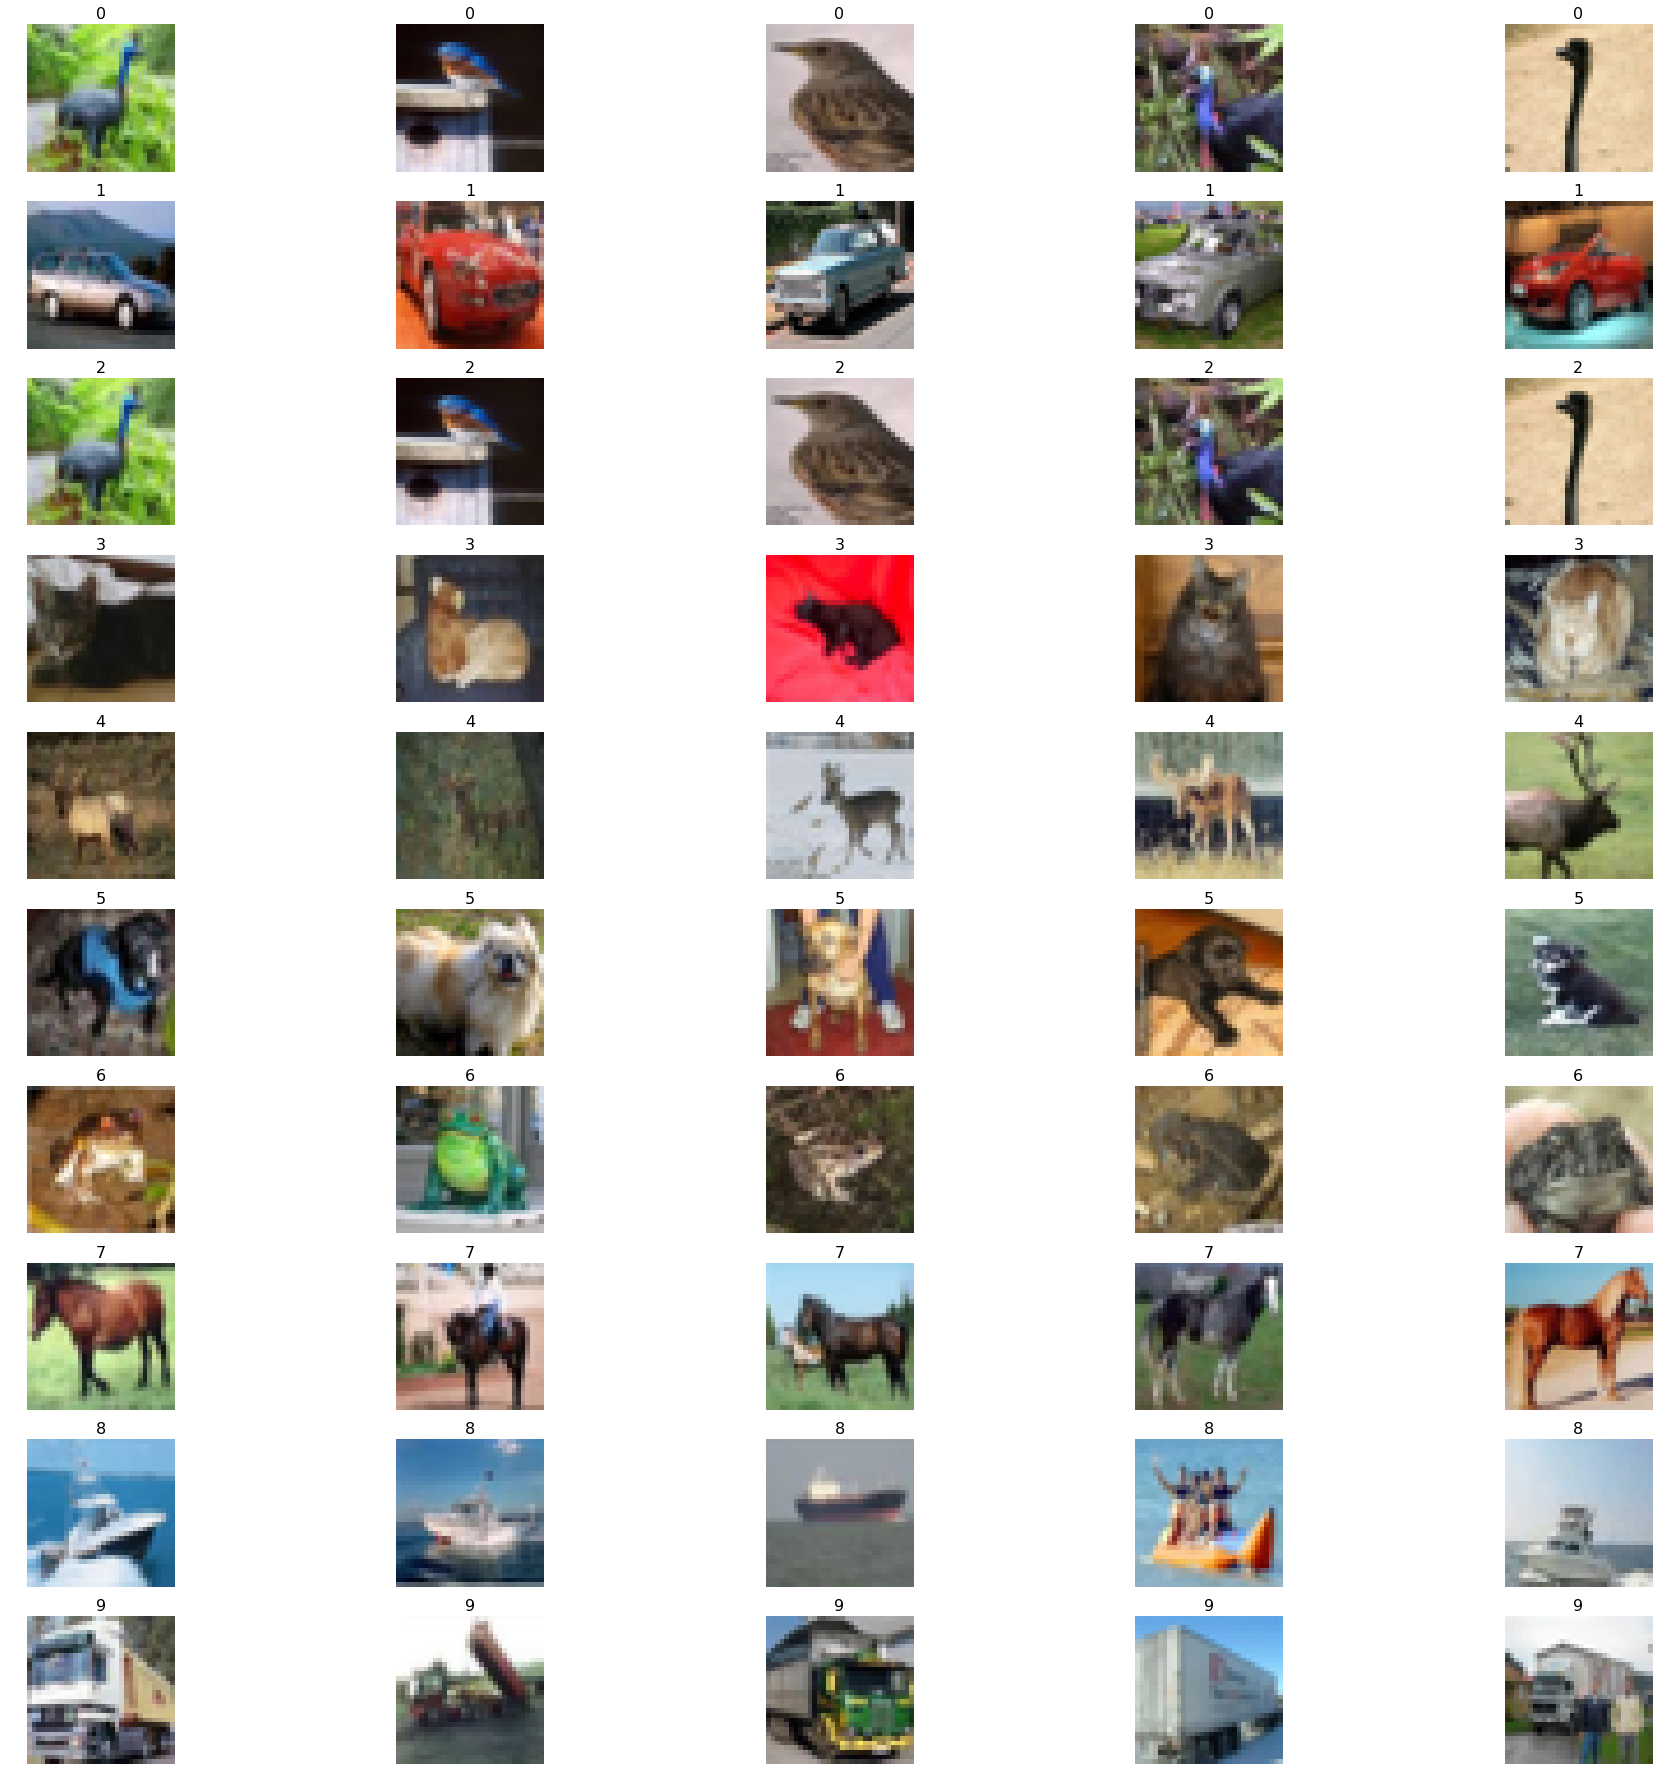

In [6]:
def plot_images(ims, fig_size=(32, 32), rows=1, titles=None):
    f = plt.figure(figsize=fig_size)
    cols = len(ims)//rows if len(ims)%2==0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
plot_images(sample, rows=10, titles=titles)

**Task 13:** Build the depicted LeNet5-inspired model using Keras standard components.
![title](model.png)

In [7]:
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, BatchNormalization, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='elu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
__________

We will now train the network. For displaying the performance we define a helper function:

In [9]:
import tensorflow.keras.backend as K
def scheduler(epoch):
    if epoch%10==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)

In [10]:
def plot_model_history(model):
    line_w = 3
    fig_size = (8, 6)
    plt.figure(0)
    plt.plot(model.history['acc'],'r', lw=line_w)
    plt.plot(model.history['val_acc'],'b', lw=line_w)
    plt.rcParams['figure.figsize'] = fig_size
    plt.xlabel("Epoch number")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.legend(['Training','Validation'])
    plt.grid(True)

**Task 14:** Train the defined model for 50 epochs and a suitable batch size and display the result.

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
my_callbacks = [LearningRateScheduler(scheduler)] #EarlyStopping(monitor="val_acc", patience=5, mode='max')

In [12]:
hist = model.fit(x_train, y_train, batch_size=64, validation_split=0.05, epochs=50, callbacks=my_callbacks)

Train on 47500 samples, validate on 2500 samples
Epoch 1/50
47500/47500 [==============================] - 11s 222us/step - loss: 2.2506 - acc: 0.3387 - val_loss: 1.4640 - val_acc: 0.4956
Epoch 2/50
47500/47500 [==============================] - 8s 177us/step - loss: 1.6826 - acc: 0.4583 - val_loss: 1.2864 - val_acc: 0.5604
Epoch 3/50
47500/47500 [==============================] - 9s 182us/step - loss: 1.4345 - acc: 0.5252 - val_loss: 1.2028 - val_acc: 0.5972
Epoch 4/50
47500/47500 [==============================] - 9s 190us/step - loss: 1.2805 - acc: 0.5687 - val_loss: 1.1844 - val_acc: 0.6004
Epoch 5/50
47500/47500 [==============================] - 9s 185us/step - loss: 1.1606 - acc: 0.6018 - val_loss: 0.9342 - val_acc: 0.6852
Epoch 6/50
47500/47500 [==============================] - 8s 176us/step - loss: 1.0728 - acc: 0.6320 - val_loss: 0.9362 - val_acc: 0.6752
Epoch 7/50
47500/47500 [==============================] - 8s 177us/step - loss: 1.0029 - acc: 0.6524 - val_loss: 0.8697 - 

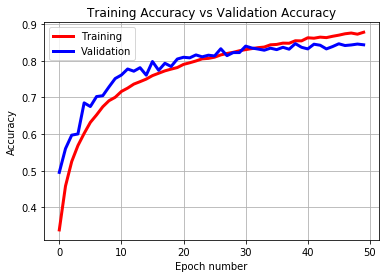

In [13]:
plot_model_history(hist)

The results can be improved in several ways, e.g., by successively reducing the learning rate (divided by two after 30 and 40 epochs), by data augmentation (`ImageDataGenerator`), and by weight regularization (see above).  
**Extra task:** Try to improve the result using one or several of the mentioned approaches.  
Hint: you need to define a suitable callback function to change the learning rate during training.

In [14]:
test_loss, test_acc = model.evaluate(x=x_test, y=y_test, batch_size=64)
print("On evaluating the model on test data :")
print("Test Loss = ", test_loss)
print("Test accuracy = ", test_acc)

10000/10000 [==============================] - 1s 56us/step
On evaluating the model on test data :
Test Loss =  0.5146983899116516
Test accuracy =  0.8321
